In [ ]:
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import copy
from collections import deque
from skactiveml.classifier import PWC
from skactiveml.stream import RandomSampler, PeriodicSampler
from skactiveml.stream import FixedUncertainty, VariableUncertainty, Split
from skactiveml.stream.budget_manager import FixedBudget

In [3]:
rand = np.random.RandomState(0)

In [4]:
init_train_length = 10
stream_length = 10000
training_size = 1000

In [5]:
X, y = sklearn.datasets.make_classification(n_samples=init_train_length + stream_length, random_state=rand.tomaxint(), shuffle=True)
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]

In [6]:
budget_manager = FixedBudget(0.1)
clf = PWC()
query_strategies = {
    'RandomSampler': RandomSampler(budget_manager=copy.copy(budget_manager), random_state=rand.tomaxint()),
    'PeriodicSampler': PeriodicSampler(budget_manager=copy.copy(budget_manager), random_state=rand.tomaxint()),
    'FixedUncertainty': FixedUncertainty(clf, budget_manager=copy.copy(budget_manager), random_state=rand.tomaxint()),
    'VariableUncertainty': VariableUncertainty(clf, budget_manager=copy.copy(budget_manager), random_state=rand.tomaxint()),
    'Split': Split(clf, budget_manager=copy.copy(budget_manager), random_state=rand.tomaxint(), s=0.1)
}
# query_strategies = {
#     'VariableUncertainty': VariableUncertainty(clf, budget_manager=copy.copy(budget_manager), random_state=rand.tomaxint()),
# }

0.8692 RandomSampler
0.8688 PeriodicSampler
0.8631 FixedUncertainty
0.9285 VariableUncertainty
0.9243 Split


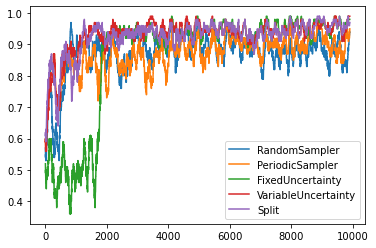

In [7]:
for query_strategy_name, query_strategy in query_strategies.items():
    X_train = deque(maxlen=training_size)
    X_train.extend(X_init)
    y_train = deque(maxlen=training_size)
    y_train.extend(y_init)
    clf.fit(X_train, y_train)
    correct_classifications = []
    for t, (x_t, y_t) in enumerate(zip(X_stream, y_stream)):
        correct_classifications.append(clf.predict(x_t.reshape([1, -1]))[0] == y_t)
        #correct_classifications.append(query_strategy.theta)
        sampled_indices = query_strategy.query(x_t.reshape([1, -1]))
        if len(sampled_indices):
            X_train.append(x_t)
            y_train.append(y_t)
            clf.fit(X_train, y_train)
    print(np.sum(correct_classifications)/stream_length, query_strategy_name)
    cumsum_correct_classifications = np.cumsum(correct_classifications)
    smoothing_window_length = 100
    plt.plot((cumsum_correct_classifications[smoothing_window_length:]-cumsum_correct_classifications[:-smoothing_window_length])/smoothing_window_length, label=query_strategy_name)
plt.legend()